## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [2]:
# Generate synthetic dataset
np.random.seed(2)
N = 10000
M = 5
K = 2
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)



(0, 1)   [0.49239541 0.12333361]
(0, 2)   [0.59469623 0.49179015]
(1, 1)   [0.47833102 0.39730134]
(1, 2)   [0.28418377 0.65734387]
(2, 1)   [0.36968921 0.34014455]
(2, 2)   [0.65902045 0.57622788]
(3, 1)   [0.22112195 0.56222031]
(3, 2)   [0.26599588 0.80680163]
(4, 1)   [0.86857776 0.54481315]
(4, 2)   [0.86190534 0.17168093]
((0, 1), 0, 0)   [0.55472148 0.15875785]
((0, 1), 0, 1)   [0.48531009 0.18687782]
((0, 1), 0, 2)   [0.21444397 0.63707078]
((0, 1), 1, 0)   [0.3034108  0.19625112]
((0, 1), 1, 1)   [0.29827559 0.41484366]
((0, 1), 1, 2)   [0.52100874 0.2815689 ]
((0, 1), 2, 0)   [0.67636605 0.53476285]
((0, 1), 2, 1)   [0.55471305 0.44820339]
((0, 1), 2, 2)   [0.81427371 0.62200376]
((1, 2), 0, 0)   [0.24606874 0.73067711]
((1, 2), 0, 1)   [0.96809597 0.55000753]
((1, 2), 0, 2)   [0.90056806 0.40745229]
((1, 2), 1, 0)   [0.61042971 0.48479137]
((1, 2), 1, 1)   [0.49307254 0.79890327]
((1, 2), 1, 2)   [0.58204376 0.958368  ]
((1, 2), 2, 0)   [0.58978734 0.17388543]
((1, 2), 2, 1)

sig
 [[ 2.09303935e-01 -1.51689687e-01  1.21422722e-02 -1.23516572e-02
  -2.25015371e-03  2.64970419e-03 -2.29124393e-04  2.59065113e-04
  -1.37024711e-06 -8.04656986e-06  4.37710242e-03  6.75205974e-03
  -6.70124999e-03 -4.19967299e-03 -1.19267092e-03 -7.89751252e-04
   1.12891745e-03  1.21724423e-03 -1.10368119e-04 -7.78927799e-05
   1.22196197e-04  7.89342356e-05  1.04126897e-01  8.39675543e-02
  -6.61459919e-02 -7.25125446e-02]
 [-1.51689687e-01  2.49926563e-01 -1.05379458e-02  1.80265218e-02
   3.33495221e-03 -3.21127233e-03  3.48291200e-04 -3.56868623e-04
   3.22296242e-06  1.22742170e-05 -3.79876743e-03 -5.85992792e-03
   9.78008276e-03  6.12917731e-03  1.76765725e-03  1.17049012e-03
  -1.36817588e-03 -1.47522231e-03  1.67770198e-04  1.18404546e-04
  -1.68328294e-04 -1.08733869e-04 -7.54643069e-02 -6.08541452e-02
   1.08983285e-01  1.19472928e-01]
 [ 1.21422722e-02 -1.05379458e-02  2.48132203e-01 -2.02165584e-01
  -3.64787677e-02  4.78787071e-02 -3.65462424e-03  4.38617596e-03
 

In [3]:
data.mu_true

array([[0.29826734],
       [0.50856955],
       [0.45678199],
       [0.44258659],
       [0.44034497],
       [0.45126135],
       [0.47052543],
       [0.40754779],
       [0.47262973],
       [0.32114327],
       [0.16466288],
       [0.25400676],
       [0.24012028],
       [0.15048337],
       [0.23340034],
       [0.15455077],
       [0.19226177],
       [0.20730438],
       [0.22664984],
       [0.15995911],
       [0.19223271],
       [0.12417524],
       [0.14838542],
       [0.11965747],
       [0.22176746],
       [0.24311258]])

In [4]:
data.O_true.shape

(26, 26)

In [5]:
print(data.E)
#print(data.sig_inv_hp[0,6])

[(0, 1), (1, 2), (2, 3), (3, 4)]


In [6]:
#data.c_tree.c_data

In [7]:
# mask the diagonals so we don't get influenced by them unfairly
'''sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
for j in range(M-1):
    sg_no_diag[2*M+j*4:2*M+j*4+4,2*M+j*4:2*M+j*4+4] = np.zeros([4,4])
'''
print(data.E)
#visualize_matrix(np.abs(data.sig_inv))
#visualize_matrix(np.abs(sg_no_diag))

V = np.copy(data.sig_this)
R_s = np.zeros([1,2])
R_s[0,0] = 1
R_s[0,1] = -1
#R = np.zeros([7,14])
R = np.zeros([9,26])



print('\n\n\n')

for i in range(5):
#for i in range(7):
    R[i:i+1, 2*i:2*i+2] = R_s

for i in range(4):
    R[5+i:5+i+1, 10+4*i : 10+4*i+2 ] = R_s
    R[5+i:5+i+1, 10+4*i+2 : 10+4*i+4 ] = R_s
    
print(R)
roll = R @ V @ R.T
#print(np.linalg.inv(roll))


R_mu = R @ data.mu_true 

#print('\n\n\n')




#print(np.linalg.inv(data.sig_this))
#print(data.big_sig_inv)

[(0, 1), (1, 2), (2, 3), (3, 4)]




[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.
   0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1. -1.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.

[[ 1.31760690e+00 -1.13701369e-02  1.38392246e-02  7.17648199e-05
  -6.03549359e-05 -1.38025266e-02  8.18159797e-06  6.91548127e-05
  -8.14399652e-02]
 [-1.13701369e-02  6.06095876e+00 -5.63307541e-03 -1.53549603e-03
   1.29136761e-03  2.63099910e-01 -1.75055287e-04 -1.47965173e-03
  -6.00852730e+00]
 [ 1.38392246e-02 -5.63307541e-03  1.21788027e+01  1.34533654e-03
  -6.06005347e-03 -1.21648751e+01 -1.37260507e-01  6.94362203e-03
   3.35100866e-03]
 [ 7.17648199e-05 -1.53549603e-03  1.34533654e-03  1.10432209e+01
  -1.23743316e-03 -1.59262902e-03 -1.10437834e+01  1.99284997e-02
   1.73770236e-05]
 [-6.03549359e-05  1.29136761e-03 -6.06005347e-03 -1.23743316e-03
   1.10537833e+01  1.33941704e-03  1.73262236e-02 -1.10171891e+01
  -1.46142518e-05]
 [-1.38025266e-02  2.63099910e-01 -1.21648751e+01 -1.59262902e-03
   1.33941704e-03  1.34581949e+01 -1.81568774e-04 -1.53470686e-03
  -3.34212266e-03]
 [ 8.18159797e-06 -1.75055287e-04 -1.37260507e-01 -1.10437834e+01
   1.73262236e-02 -1.8156877

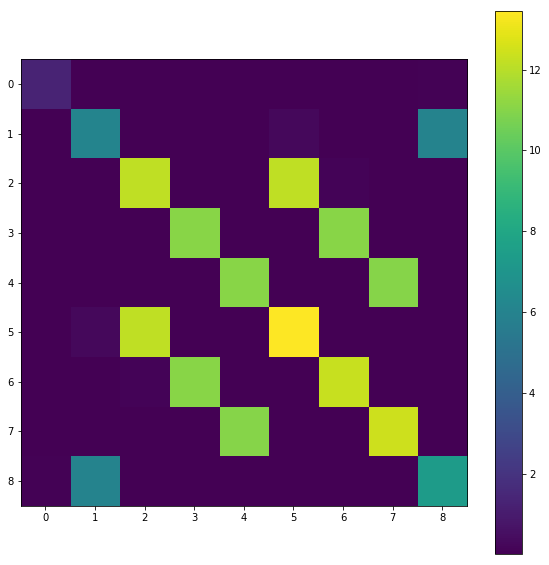

In [8]:

visualize_matrix(np.abs(np.linalg.inv(roll)))
print(np.linalg.inv(roll))



In [9]:
data.k=1
print(data.k)
lm = LabelModel(k=data.k, class_balance=data.p)

squashed_O = R @ data.O_true @ R.T

print(squashed_O)

#data2 = SingleTaskTreeDepsGenerator(N, M, k=1, edge_prob=EDGE_PROB)

#print(data2.c_tree.c_data)

1
1
[[ 8.06836889e-01  5.00730740e-02 -9.15034309e-03 -1.44376864e-02
  -3.18422089e-02 -1.06502258e-02 -1.46142040e-02 -2.83168284e-02
   5.00730740e-02]
 [ 5.00730740e-02  8.99368582e-01 -1.78980797e-01 -1.68564273e-02
   2.39390452e-03 -1.78980797e-01 -1.69625507e-02  2.31173605e-03
   7.32922940e-01]
 [-9.15034309e-03 -1.78980797e-01  8.91606322e-01  9.38921771e-02
  -2.88270488e-03  8.09273297e-01  9.38921771e-02 -2.97861689e-03
  -1.45871435e-01]
 [-1.44376864e-02 -1.68564273e-02  9.38921771e-02  8.78073220e-01
  -1.36674141e-03  8.59652684e-02  7.87517257e-01 -1.36674141e-03
  -1.40094786e-02]
 [-3.18422089e-02  2.39390452e-03 -2.88270488e-03 -1.36674141e-03
   7.93773003e-01 -1.07151447e-03 -9.51882256e-05  7.03016907e-01
   1.31691947e-03]
 [-1.06502258e-02 -1.78980797e-01  8.09273297e-01  8.59652684e-02
  -1.07151447e-03  8.09273297e-01  8.59652684e-02 -1.32210165e-03
  -1.45871435e-01]
 [-1.46142040e-02 -1.69625507e-02  9.38921771e-02  7.87517257e-01
  -9.51882256e-05  8.596

In [10]:
print(data.c_tree.c_data)

OrderedDict([((0,), {'start_index': 0, 'end_index': 2, 'max_cliques': {3}, 'size': 1, 'members': {0}}), ((1,), {'start_index': 2, 'end_index': 4, 'max_cliques': {0, 3}, 'size': 1, 'members': {1}}), ((2,), {'start_index': 4, 'end_index': 6, 'max_cliques': {0, 1}, 'size': 1, 'members': {2}}), ((3,), {'start_index': 6, 'end_index': 8, 'max_cliques': {1, 2}, 'size': 1, 'members': {3}}), ((4,), {'start_index': 8, 'end_index': 10, 'max_cliques': {2}, 'size': 1, 'members': {4}}), ((1, 2), {'start_index': 10, 'end_index': 14, 'max_cliques': {0}, 'size': 2, 'members': {1, 2}}), ((2, 3), {'start_index': 14, 'end_index': 18, 'max_cliques': {1}, 'size': 2, 'members': {2, 3}}), ((3, 4), {'start_index': 18, 'end_index': 22, 'max_cliques': {2}, 'size': 2, 'members': {3, 4}}), ((0, 1), {'start_index': 22, 'end_index': 26, 'max_cliques': {3}, 'size': 2, 'members': {0, 1}})])


In [11]:

# Get the exact O_inv
O_inv = np.linalg.inv(data.O_true)

# Generate c_data: clique data structure
# Normally this is assembled while computing O, but if we pass in O
# ourselves, we need to construct this data structure too...

data.k = 1

lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.001,
    l2=0,
    O_inv_prec=1024,
    O=squashed_O,
    #O_inv=O_inv,
    c_data=data.c_tree.c_data_1
)

ZZ_true = np.abs(np.linalg.inv(squashed_O) - np.linalg.inv(roll))
print(ZZ_true)
"\n\n"
ZZ = np.abs(lm.Z.detach().numpy() @ lm.Z.detach().numpy().T)
print(ZZ)
"\n\n"

print(np.abs(ZZ_true - ZZ))
"\n\n"



mu_est = lm.mu.detach().numpy() # Note: we can swap column order
mu_est_swapped = lm.mu.detach().numpy()[:,::-1] # Note: we can swap column order
print(f"Average absolute error: {np.mean(np.abs(mu_est -R_mu))}")
print(f"Average absolute error -- cols swapped: {np.mean(np.abs(mu_est_swapped - R_mu))}")

Estimating Z...
[Epoch 0] Loss: 18.384176
[Epoch 5000] Loss: 0.002492
[Epoch 10000] Loss: 0.001416
[Epoch 15000] Loss: 0.001416
[Epoch 20000] Loss: 0.001416
[Epoch 25000] Loss: 0.001416
[Epoch 30000] Loss: 0.001416
[Epoch 35000] Loss: 0.001416
[Epoch 40000] Loss: 0.001416
[Epoch 45000] Loss: 0.001416
[Epoch 49999] Loss: 0.001416
Estimating \mu...
[Epoch 0] Loss: 15.942109
[Epoch 5000] Loss: 0.000000
[Epoch 10000] Loss: 0.000000
[Epoch 15000] Loss: 0.000000
[Epoch 20000] Loss: 0.000000
[Epoch 25000] Loss: 0.000000
[Epoch 30000] Loss: 0.000000
[Epoch 35000] Loss: 0.000000
[Epoch 40000] Loss: 0.000000
[Epoch 45000] Loss: 0.000000
[Epoch 49999] Loss: 0.000000
[[7.05121543e-02 1.11841905e-02 3.75718901e-02 1.71158021e-03
  4.84635401e-02 3.63297288e-02 2.36265230e-02 1.86127251e-03
  3.48227716e-03]
 [1.11841905e-02 1.77396534e-03 5.95941482e-03 2.71479994e-04
  7.68697925e-03 5.76239108e-03 3.74748917e-03 2.95223236e-04
  5.52336709e-04]
 [3.75718901e-02 5.95941482e-03 2.00199092e-02 9.120

In [20]:
print("mu_est")
print(mu_est)

#mu_comb = mu_est[:,0]+mu_est[:,1]

print("\nR_mu\n", np.array(R_mu))
print(f"\nAverage absolute error: {np.mean(np.abs(np.abs(mu_est)-np.abs(R_mu)))}")


mu_est
[[ 0.19868468]
 [-0.01619545]
 [ 0.00174545]
 [-0.05251294]
 [-0.17138283]
 [-0.00638848]
 [-0.05314954]
 [-0.15442708]
 [-0.01039252]]

R_mu
 [[-0.2103022 ]
 [ 0.0141954 ]
 [-0.01091638]
 [ 0.06297764]
 [ 0.15148646]
 [ 0.00029303]
 [ 0.06380696]
 [ 0.1347482 ]
 [ 0.00738283]]

Average absolute error: 0.010287890975127268


In [ ]:
visualize_matrix(np.abs(ZZ_true - ZZ))

print(np.abs(ZZ_true - ZZ))

In [ ]:
ZZ_true = np.abs(np.linalg.inv(squashed_O) - np.linalg.inv(roll))
print(ZZ_true)
print("\n\n")
ZZ = np.abs(lm.Z.detach().numpy() @ lm.Z.detach().numpy().T)
print(ZZ)
print("\n\n")

print(np.abs(ZZ_true - ZZ))
print("\n\n")



In [ ]:
visualize_matrix(lm.mask)

In [ ]:
np.hstack((lm.mu.detach().numpy(), data.mu_true))

In [ ]:
sig_inv_rec = O_inv + (lm.Z @ lm.Z.t()).detach().numpy()
np.linalg.eig(sig_inv_rec)

In [ ]:
A = O_inv - data.sig_inv
B = (lm.Z @ lm.Z.t()).detach().numpy()

print(A)
print(B)

print(np.sum(np.abs(A+B))/(56**2))
visualize_matrix(np.abs(A+B))



In [ ]:
mu = lm.mu.detach().numpy()
diff = np.abs(np.abs(mu @ mu.T) - np.abs(data.mu_true @ data.mu_true.T))
visualize_matrix(diff)
print(diff)


In [ ]:
d2 = np.abs(np.abs(mu[:,::-1]) - np.abs(data.mu_true))
print(d2)
visualize_matrix(d2)

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [ ]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [ ]:
lm.config['higher_order_cliques'] = True

In [ ]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''

In [ ]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [ ]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [ ]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(mu)
print(mu_est)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

### Sanity check that the true $Z$ gets lower loss

In [ ]:
sorted(np.linalg.eig(O)[0])[::-1]

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]